# 1. Introduction
Harmful use of alcohol causes more than 5% of the global disease burden. The death of more than [3 million people](https://www.who.int/news-room/detail/21-09-2018-harmful-use-of-alcohol-kills-more-than-3-million-people-each-year--most-of-them-men) a year is caused by the substance. Simultaneously it is source of a [1344 billion dollar industry](https://www.statista.com/statistics/696641/market-value-alcoholic-beverages-worldwide/), and an important cultural factor. This makes it a highly important, and highly complex, matter for regulators which have to take into account many aspects when creating policies.

The goal of this notebook is to aggregate different alcohol control policies to understand which are the most common and test the correlation between alcohol consumption and different alcohol control policies


## 1.1 Libraries importation

In [1]:
# import libraries
from preprocess_data import *
import os
import pandas as pd
import numpy as np
import csv
import folium
import geopandas
import warnings
import re
from folium import plugins
from IPython.core.display import display, HTML
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

# import geoplot
pylab.rcParams['figure.figsize'] = 20, 20

## 1.2 Define file paths

In [2]:
#original_file_PATH_definitions
projectdata_PATH = "../data/projectdata/"
dataprocessed_PATH = "../data/dataprocessed/"

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## 1.3 Defines functions used to preprocess the project data

In order to keep this notebook as clean as possible, the functions where written in the python package `preprocess_data`

1. We have divided all the countries in the database into eight parts according to the United Nations geographical division criteria.
2. This is because we take into account that countries in the same region have similar political conditions, living habits and cultural background, such as countries in the EU, while countries in different regions are quite different in these aspects.
3. Therefore, our subsequent analysis will be based on the results of the following country segmentation.

## 1.4 DataSets Overview

**DataSet 1. Pure alcohol consumption, litres per capita, age 15+**


* Data type: Numerical

* Unit: Litres per capita

* Rationale: This is the indicator we want to analyze

* Method of estimation: The national authorities of a given country respond to the Global Survey on Alcohol and Health.

* Year of measurement: 2010 and 2016


Short name: Alcohol consumption


Total countries:194

In [4]:
display(HTML('<iframe id=\'rightframe\' name=\'leftiframe\' width="100%" src=\'http://apps.who.int/gho/data/node.gisah.A1029\'></iframe><br>'))

**DataSet 2. Alcohol control policies: Global information system on alcohol and health**
* Short name: Policies

* Data type: Categorical

* Rationale: Legislators create alcohol control policies with the goal of affecting several behaviours related to alcohol consumption and generally to decrease the consumption

* Method of estimation: The national authorities of a given country respond to the Global Survey on Alcohol and Health.

* Year of measure: 2016

* List of choosen datasets in this section:
    - Age limits to serve (on-premise service) and sell (off-premise sales) alcohol
    - Community action (earmarked funds for community action, provision of technical tools tailored to communities, training programmes, community programmes and policies for subgroups at particular risk)
    - Licensing requirements for retail sales and alcohol production
    - Restrictions on alcohol use in public places pertain to: education buildings, government offices, healthcare establishments, leisure events, parks and streets, public transport, religious places, sporting events, workplace. 

# link this to the hierarchy df

In [5]:
display(HTML('<iframe id=\'rightframe\' name=\'leftiframe\' width="100%" src=\'http://apps.who.int/gho/data/node.gisah.A1119\'></iframe><br>'))

**DataSet 3. Human Development Reports: GDP, Education Index, Unemployment, Median age, Human Development Index**

* Short name: HDR factors

* Data type: Numerical

* Rationale: Several socio-economical factors can influence the alcohol consumption of a population. For this reason we have chosen several indicators used by the UN development agency, to see what influence they have and how their influence compares to alcohol control policies.

* Method of estimation: Answer from statistical department of the respective governments.

* Year of measure: Yearly from 2000, every five years before

In [6]:
display(HTML('<iframe id=\'rightframe\' name=\'leftiframe\' width="100%" src=\'http://hdr.undp.org/en/data\'></iframe><br>'))

**DataSet 4. United Nations Regional Groups**

* Short name: Regions

* Data type: Categorical

* Rationale: Alcohol consumption of a country is probably highly dependent from which region of the world the country is situated

In [7]:
display(HTML('<iframe id=\'rightframe\' name=\'leftiframe\' height="100%" width="100%" src=\'https://en.wikipedia.org/wiki/United_Nations_Regional_Groups\'></iframe><br>'))



**DataSet 5. Major Religions in Countries**

* Short name: Religions

* Data type: Categorical

* Rationale: Religion and its approach is a major factor to take into account when comparing countries as many religions dictate a certain approach to consumption

In [8]:
display(HTML('<iframe id=\'rightframe\' name=\'leftiframe\' width="100%" src=\'https://www.nationmaster.com/country-info/stats/Religion/Religions/All\'></iframe><br>'))

# 2. Preprocessing
## 2.1 Alcohol consumption



In [9]:
process_country_name(projectdata_PATH+"Consumption.csv", dataprocessed_PATH+"Consumption_namecleaned.csv", 0)

In [10]:
df_consumption = pd.read_csv(dataprocessed_PATH + "Consumption_namecleaned.csv", header=0, sep=',', names=['Country', '2015-2017', '2009-2011'])
df_consumption.head()

Country        2015-2017       2009-2011
0  Afghanistan          0 [0-0]         0 [0-0]
1      Albania      5 [4.9-5.1]   5.7 [5.6-5.9]
2      Algeria    0.6 [0.6-0.6]   0.4 [0.4-0.4]
3      Andorra  10.1 [9.9-10.3]  11 [10.8-11.2]
4       Angola      5 [4.9-5.1]   7.5 [7.3-7.6]

### Split the consumption value and 95%CI 

In [11]:
df_consumption = pd.read_csv(dataprocessed_PATH + "Consumption_namecleaned.csv", header=0, sep=',', names=['Country', '2015-2017', '2009-2011'])
df_consumption['Alcohol_per_capita_2015-2017'], df_consumption['Alcohol_per_capita_2015-2017_95%CI'] = df_consumption['2015-2017'].str.split('[', 1).str
df_consumption['Alcohol_per_capita_2009-2011'], df_consumption['Alcohol_per_capita_2009-2011_95%CI'] = df_consumption['2009-2011'].str.split('[', 1).str
df_consumption = df_consumption[['Country', 'Alcohol_per_capita_2015-2017', 'Alcohol_per_capita_2015-2017_95%CI', 
                                 'Alcohol_per_capita_2009-2011', 'Alcohol_per_capita_2009-2011_95%CI']]
for row in df_consumption.iterrows():
    if isinstance(row[1][2], str):
        row[1][2] = row[1][2].replace("]", "")
    if isinstance(row[1][4], str):
        row[1][4] = row[1][4].replace("]", "")
df_consumption = df_consumption[1:]
df_consumption['Alcohol_per_capita_2009-2011'].astype(dtype=float)
df_consumption['Alcohol_per_capita_2015-2017'].astype(dtype=float)
df_consumption.to_csv(dataprocessed_PATH + "Consumption_final.csv", index=False, sep=',')

In [12]:
df_consumption = pd.read_csv(dataprocessed_PATH + "Consumption_final.csv").set_index('Country')
df_consumption.head()

Alcohol_per_capita_2015-2017  \
Country                                           
Albania                                     5.0   
Algeria                                     0.6   
Andorra                                    10.1   
Angola                                      5.0   
Antiguaandbarbuda                           8.5   

                  Alcohol_per_capita_2015-2017_95%CI  \
Country                                                
Albania                                      4.9-5.1   
Algeria                                      0.6-0.6   
Andorra                                     9.9-10.3   
Angola                                       4.9-5.1   
Antiguaandbarbuda                            8.3-8.6   

                   Alcohol_per_capita_2009-2011  \
Country                                           
Albania                                     5.7   
Algeria                                     0.4   
Andorra                                    11.0   
Angola                                      7.5   
Antiguaandbarbuda                           7.9   

                  Alcohol_per_capita_2009-2011_95%CI  
Country                                               
Albania                                      5.6-5.9  
Algeria                                      0.4-0.4  
Andorra                                    10.8-11.2  
Angola                                       7.3-7.6  
Antiguaandbarbuda                              7.7-8

## 2.2 Policies

### 2.2.1 Clean the 4 simplest datasets: Tax, Liscence, Community_action, Health_warning 

* Data transformation: from categorical to numerial
    * Type of transformations: Turning Yes/No to 1/0
* Missing data handling policy: the function `preprocess_data_file` calls the function `leave_out_nodata` which removes the countries for which we have absolutely no data (i.e. Afghanistan is often from those countries)

In [13]:
preprocess_data_file(projectdata_PATH + "Tax.csv", dataprocessed_PATH + "Tax.csv")
preprocess_data_file(projectdata_PATH + "Licence_production.csv", dataprocessed_PATH + "Licence_production.csv")
preprocess_data_file(projectdata_PATH + "Licence_retail.csv", dataprocessed_PATH + "Licence_retail.csv")
preprocess_data_file(projectdata_PATH + "Community_actions.csv", dataprocessed_PATH + "Community_actions.csv")
preprocess_data_file_one(projectdata_PATH + "Health_warning.csv", dataprocessed_PATH + "Heatlh_warning.csv")

In [14]:
# print every file after cleaning
df_tax = pd.read_csv(dataprocessed_PATH + "Tax.csv", sep=',')

In [15]:
df_liscence_production = pd.read_csv(dataprocessed_PATH + "Licence_production.csv", sep=',')

In [16]:
df_liscence_retail = pd.read_csv(dataprocessed_PATH + "Licence_retail.csv", sep=',')

In [17]:
df_community_actions = pd.read_csv(dataprocessed_PATH + "Community_actions.csv", sep=',')

In [18]:
df_health_warning = pd.read_csv(dataprocessed_PATH + "Heatlh_warning.csv", sep=',')

### 2.2.2 Clean public_use dataset, change text to valuse

Replacing text value according to below:

ban                                               1

partial restriction                             0.5

voluntary/self-restricted                       0.3 (this parameter can be changed)

no restrictions                                  0

leave out nodata rows:

No data        

In [19]:
b = pd.read_csv(projectdata_PATH + "Public_use.csv", header=None, sep=',')
b = pd.DataFrame(b)
for i in range(2, 4):
    print("Value_counts for column", i, "\n")
    print(b[i].value_counts())

Value_counts for column 2 

ban                               108
voluntary/self-restricted          28
No data                            27
partial restriction                19
no restrictions                    12
 Educational buildings              1
Restrictions on alcohol use in      1
Name: 2, dtype: int64
Value_counts for column 3 

ban                               91
voluntary/self-restricted         30
No data                           27
no restrictions                   24
partial restriction               22
 Government offices                1
Restrictions on alcohol use in     1
Name: 3, dtype: int64


In [20]:
preprocess_public_use_data(projectdata_PATH + "Public_use.csv", dataprocessed_PATH + "Public_use.csv")
df_public_use = pd.read_csv(dataprocessed_PATH + "Public_use.csv", sep=',')

### 2.2.3 Clean age_limit data set,  change text to value

Using max min scale, (0, age value, Total ban=50) ~ (0,1)

None              0

15  16  17  18  19  20  21  25

Total ban          50

Subnational 2      drop

No data  21       drop


In [21]:
preprocess_age_limits(projectdata_PATH + "Age_limits.csv", dataprocessed_PATH + 'Age_limits.csv')
df_age_limits = pd.read_csv(dataprocessed_PATH + 'Age_limits.csv', sep=',')

### 2.2.4 Final DataFrame with the policies

In [22]:
# creates one DataFrame with all the policies
df_policy = df_age_limits.set_index(['Country','Year']).join([df_community_actions.set_index(['Country','Year']), 
                                                  df_health_warning.set_index(['Country','Year']),
                                                  df_liscence_production.set_index(['Country','Year']),
                                                  df_liscence_retail.set_index(['Country','Year']),
                                                  df_tax.set_index(['Country','Year']),
                                                  df_public_use.set_index(['Country','Year'])],
                                                  how='outer')
df_policy = df_policy.reset_index('Year')
df_policy = df_policy.drop(labels='Year', axis='columns')

### 2.2.5 Handling missing values

In [23]:
# drops countries where there is no data in all columns
before=df_policy.shape[0]
df_policy=df_policy.dropna(axis='rows', how='all')
after=df_policy.shape[0]
print('Initial #countries:', before, '; #countries removed:', before-after)

Initial #countries: 194 ; #countries removed: 17


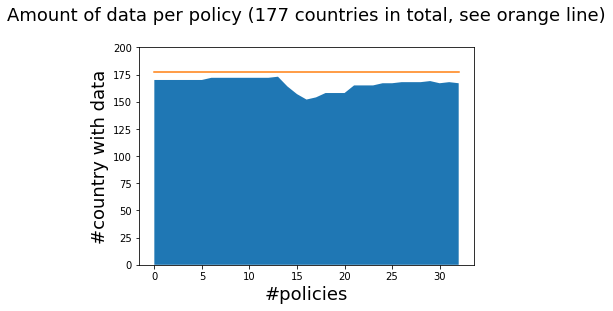

In [24]:
# visualize how many countries are missing per policy
n_countries=df_policy.shape[0]
plt.stackplot(range(len(df_policy.columns)),df_policy.count())
plt.plot(np.linspace(n_countries,n_countries,len(df_policy.columns)), )
plt.xlabel("#policies", fontsize=18)
plt.ylabel("#country with data", fontsize=18)
plt.ylim(0, 200)
plt.title('Amount of data per policy (' + str(n_countries) +' countries in total, see orange line)\n', fontsize=18)
plt.show()

### 2.2.5 Imputation
As there is a low number of missing data, we choose to impute the missing values with mean so as to keep as much meaningful data as possible

In [25]:
df_policy.fillna(df_policy.mean(), inplace=True)
print('Final shape:', df_policy.shape)

Final shape: (177, 33)


## 2.3 HDR factors

In [26]:
#creates dataframes for each HDR factor
df_hdi = pd.read_csv(projectdata_PATH + "Human_Development_Index.csv").replace('..',np.nan)
df_unempl = pd.read_csv(projectdata_PATH + "Unemployment.csv").replace('..',np.nan)
df_median = pd.read_csv(projectdata_PATH + "Median_age.csv").replace('..',np.nan)
df_gdp = pd.read_csv(projectdata_PATH + "GDP.csv").replace('..',np.nan)
df_edu = pd.read_csv(projectdata_PATH + "Education_Index.csv").replace('..',np.nan)

In [27]:
# agglomerates all HDR factor in one DataFrame
df_hdr = df_hdi.set_index(['Country','Year']).join([df_unempl.set_index(['Country','Year']), 
                                                  df_median.set_index(['Country','Year']),
                                                  df_gdp.set_index(['Country','Year']),
                                                  df_edu.set_index(['Country','Year'])],
                                                  how='outer')
df_hdr = df_hdr.reset_index('Year')
df_hdr = df_hdr.drop(labels='Year', axis='columns')
df_hdr = df_hdr.rename({'iso3':'Code'}, axis=1)
df_hdr = df_hdr[:-1].astype(dtype=float)
print('Final shape:', df_hdr.shape)
df_hdr.head()

Final shape: (195, 5)


HDI_2016  Unemployment, total (% of labour force)  \
Country                                                          
Afghanistan     0.494                                      8.8   
Albania         0.782                                     15.2   
Algeria         0.753                                     10.2   
Andorra         0.856                                      NaN   
Angola          0.577                                      7.7   

             Median age (years)  \
Country                           
Afghanistan                17.3   
Albania                    36.2   
Algeria                    27.5   
Andorra                     NaN   
Angola                     16.4   

             Gross domestic product (GDP) per capita (2011 PPP $)  \
Country                                                             
Afghanistan                                             1803.0      
Albania                                                11356.0      
Algeria                                                13921.0      
Andorra                                                    NaN      
Angola                                                  5972.0      

             Education Index  
Country                       
Afghanistan            0.410  
Albania                0.742  
Algeria                0.663  
Andorra                0.714  
Angola                 0.487

In [28]:
#standardizing names as used for policies
as_list = df_hdr.index.tolist()
idx = as_list.index('Korea (Democratic People\'s Rep. of)')
as_list[idx] = 'Democratic People\'s Republic of Korea'
idx = as_list.index('Korea (Republic of)')
as_list[idx] = 'Republic of Korea'
idx = as_list.index('Moldova (Republic of)')
as_list[idx] = 'Republic of Moldova'
idx = as_list.index('The former Yugoslav Republic of Macedonia')
as_list[idx] = 'Republic of North Macedonia'
idx = as_list.index('United Kingdom')
as_list[idx] = 'United Kingdom of Great Britain and Northern Ireland'
idx = as_list.index('United States')
as_list[idx] = 'United States of America'
idx = as_list.index('Congo (Democratic Republic of the)')
as_list[idx] = 'Democratic Republic of the Congo'
idx = as_list.index('Eswatini (Kingdom of)')
as_list[idx] = 'Eswatini'
df_hdr.index = as_list

## 2.4 Regions, religions

We have divided all the countries in the database into eight parts according to the United Nations geographical division criteria.

Reason: we think that countries from the same region have similar political conditions, living habits and cultural background; for example countries in the EU. However countries from different regions could be quite different in these aspects. Hence, we would like to see how does alcohol consumption clusters on regions.

In [29]:
df_rel_reg = pd.read_csv(projectdata_PATH + "Country_list.csv")

# sanitizes the religion data and save to csv
df_rel_reg.Religion = df_rel_reg.Religion.apply(lambda x: x.strip(' .'))
df_rel_reg.Religion = df_rel_reg.Religion.replace({'indigenous beliefs':'Indigenous beliefs',
                                                      'Islam: Sunni':'Islam Sunni'})
df_rel_reg.to_csv(dataprocessed_PATH + "Country_list.csv")

print('List of regions: ', df_rel_reg.Region.unique(), '\n\nList of religions: ', df_rel_reg.Religion.unique())

List of regions:  ['African Group' 'Asia-Pacific Group' 'Western European and Others Group'
 'Eastern European Group' 'Latin American and Caribbean Group'] 

List of religions:  ['Islam' 'Indigenous beliefs' 'Christian' 'Roman Catholic' 'Islam Sunni'
 'Protestant' 'traditional' 'Hindu' 'Mozambique' 'Buddhist'
 'Officially atheist' 'Orthodox' 'Shintoist and Buddhist'
 'Congregationalist' 'Church of Melanesia' 'Church of Tuvalu'
 'Armenian Apostolic' 'Catholic' 'Baptist' 'Judaism' 'Anglican']


We have some countries that are not in our region and religion dataset. This is probably due to the fact that the regional division is from a UN dataset and some smaller countries are not part of the UN

## 2.5 Dataframe with all features

In [30]:
# Add latitude and longitude into country list
process_countries(dataprocessed_PATH + "Country_list.csv", dataprocessed_PATH + "Country_list_lat_long_final.csv")
df_country_location = pd.read_csv(dataprocessed_PATH + 'Country_list_lat_long_final.csv', sep=',')
df_country_location=df_country_location.set_index('Country').drop(labels='Number',axis=1)
df_country_location.head()

Successfully Converted: 173


iso2 iso3    latitude  longitude         Region  \
Country                                                       
Algeria       DZ  DZA   28.033886   1.659626  African Group   
Angola        AO  AGO  -11.202692  17.873887  African Group   
Benin         BJ  BEN     9.30769   2.315834  African Group   
Botswana      BW  BWA  -22.328474  24.684866  African Group   
Burkinafaso   BF  BFA   12.238333  -1.561593  African Group   

                       Religion  
Country                          
Algeria                   Islam  
Angola       Indigenous beliefs  
Benin        Indigenous beliefs  
Botswana              Christian  
Burkinafaso               Islam

In [31]:
df_all = df_policy.join([df_hdr, df_country_location.drop(labels={'latitude','longitude','iso2'},axis=1)], how= 'left')
df_all = df_all.dropna(axis=0, subset=['HDI_2016'])
df_all = df_all.rename({'iso3':'Code'}, axis=1)
pd.set_option('display.max_rows', df_all.shape[0]+1)
df_all.head()

Age limits off-premise sales for beer  \
Country                                              
Afghanistan                                   1.00   
Albania                                       0.36   
Algeria                                       0.36   
Andorra                                       0.36   
Angola                                        0.36   

             Age limits off-premise sales for wine  \
Country                                              
Afghanistan                                   1.00   
Albania                                       0.36   
Algeria                                       0.36   
Andorra                                       0.36   
Angola                                        0.36   

             Age limits off-premise sales for spirits  \
Country                                                 
Afghanistan                                      1.00   
Albania                                          0.36   
Algeria                                          0.36   
Andorra                                          0.36   
Angola                                           0.36   

             Age limits on-premise service for beer  \
Country                                               
Afghanistan                                    1.00   
Albania                                        0.36   
Algeria                                        0.36   
Andorra                                        0.36   
Angola                                         0.36   

             Age limits on-premise service for wine  \
Country                                               
Afghanistan                                    1.00   
Albania                                        0.36   
Algeria                                        0.36   
Andorra                                        0.36   
Angola                                         0.36   

             Age limits on-premise service for spirits  \
Country                                                  
Afghanistan                                       1.00   
Albania                                           0.36   
Algeria                                           0.36   
Andorra                                           0.36   
Angola                                            0.36   

             Government support for earmarked funds  \
Country                                               
Afghanistan                                     0.0   
Albania                                         0.0   
Algeria                                         0.0   
Andorra                                         0.0   
Angola                                          0.0   

             Government support for technical tools  \
Country                                               
Afghanistan                                     0.0   
Albania                                         0.0   
Algeria                                         0.0   
Andorra                                         0.0   
Angola                                          0.0   

             Government support for training programmes  \
Country                                                   
Afghanistan                                         0.0   
Albania                                             0.0   
Algeria                                             0.0   
Andorra                                             0.0   
Angola                                              1.0   

             Government support for at-risk groups targeted  ...  \
Country                                                      ...   
Afghanistan                                             0.0  ...   
Albania                                                 0.0  ...   
Algeria                                                 0.0  ...   
Andorra                                                 0.0  ...   
Angola                                                  0.0  ...   

             

## 2.6 Final dataframe

In [32]:
#Merge country location adn consumption dataframes
finaldf = pd.merge(df_country_location, df_consumption, on='Country')
finaldf.to_csv(dataprocessed_PATH + "Countries_finaldf.csv", index=False, sep=',', 
               header=['iso2', 'iso_a3', 'latitude', 'longitude', 'Region', 'Religion', 
                       'Alcohol_per_capita_2015-2017', 'Alcohol_per_capita_2015-2017_95%CI', 
                       'Alcohol_per_capita_2009-2011', 'Alcohol_per_capita_2009-2011_95%CI'])
finaldf.head()

iso2 iso3    latitude  longitude         Region  \
Country                                                       
Algeria       DZ  DZA   28.033886   1.659626  African Group   
Angola        AO  AGO  -11.202692  17.873887  African Group   
Benin         BJ  BEN     9.30769   2.315834  African Group   
Botswana      BW  BWA  -22.328474  24.684866  African Group   
Burkinafaso   BF  BFA   12.238333  -1.561593  African Group   

                       Religion  Alcohol_per_capita_2015-2017  \
Country                                                         
Algeria                   Islam                           0.6   
Angola       Indigenous beliefs                           5.0   
Benin        Indigenous beliefs                           1.6   
Botswana              Christian                           6.2   
Burkinafaso               Islam                           4.9   

            Alcohol_per_capita_2015-2017_95%CI  Alcohol_per_capita_2009-2011  \
Country                                                                        
Algeria                                0.6-0.6                           0.4   
Angola                                 4.9-5.1                           7.5   
Benin                                  1.5-1.6                           1.3   
Botswana                               6.1-6.3                           5.6   
Burkinafaso                              4.8-5                           4.6   

            Alcohol_per_capita_2009-2011_95%CI  
Country                                         
Algeria                                0.4-0.4  
Angola                                 7.3-7.6  
Benin                                  1.3-1.4  
Botswana                               5.5-5.8  
Burkinafaso                            4.5-4.7

# 3 Policy analysis

In this section we want to analyse what kind of policies are present in different parts of the world and understand why

## 3.1 Visualization of Alcohol consumption, Region and Religion

### 3.1.1 Initialization of using geopandas

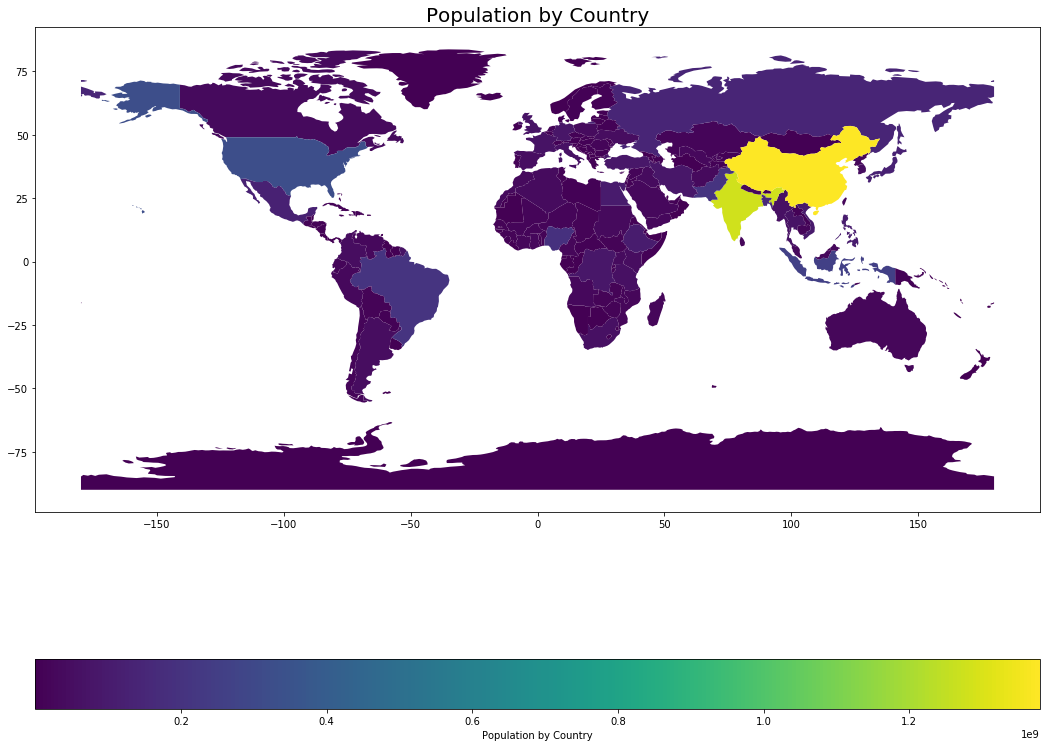

In [33]:
# Draw population of each countries
%matplotlib inline
pylab.rcParams['figure.figsize'] = 18, 18
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(1, 1)
ax.set_title("Population by Country", fontsize=20)
world.plot(column='pop_est',
           ax=ax,
           legend=True,
           legend_kwds={'label': "Population by Country",'orientation': "horizontal"})
#            cmap='OrRd',
#            scheme='quantiles')

In [34]:
# Read the panda dataframe world of the library Geopandas
world.head(5)

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

### 3.1.2 Visualization of Alcohol consumption

In [35]:
# Merging world shape data with our alcohol consumption data
finaldf = finaldf.rename(columns={'iso3':'iso_a3'})
world = world.merge(finaldf, on='iso_a3')

In [36]:
# rename the columns of the dataframe world and sort them
world = world.rename(columns={'Alcohol_per_capita_2015-2017':'Alcohol_com1'})
world = world.rename(columns={'Alcohol_per_capita_2009-2011':'Alcohol_com2'})
world['Alcohol_com1'] = world.Alcohol_com1
world['Alcohol_com2'] = world.Alcohol_com2
world['iso_a3'] = world.iso_a3
world['Region'] = world.Region
world['Religion'] = world.Religion
world.columns.values.tolist()

['pop_est',
 'continent',
 'name',
 'iso_a3',
 'gdp_md_est',
 'geometry',
 'iso2',
 'latitude',
 'longitude',
 'Region',
 'Religion',
 'Alcohol_com1',
 'Alcohol_per_capita_2015-2017_95%CI',
 'Alcohol_com2',
 'Alcohol_per_capita_2009-2011_95%CI']

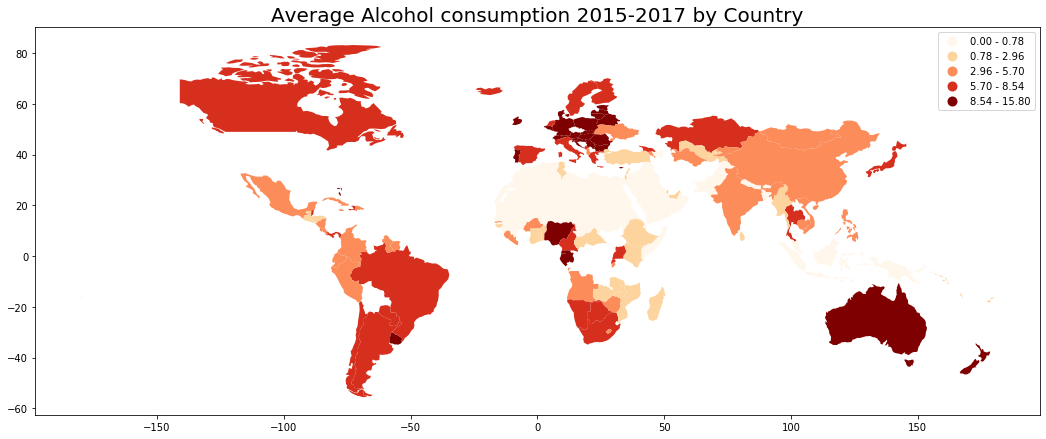

In [37]:
# Draw Alcohol consumptions by each country for the first time period 2015-2017
pylab.rcParams['figure.figsize'] = 18, 18
fig, ax = plt.subplots(1, 1)
ax.set_title("Average Alcohol consumption 2015-2017 by Country", fontsize=20)
world.plot(column='Alcohol_com1',
           ax=ax,
           legend=True,
#            legend_kwds={'labels': "Avg Alcohol_2015-2017 by Country",'legend': "horizontal"})
           cmap='OrRd',
           scheme='quantiles')
plt.show()

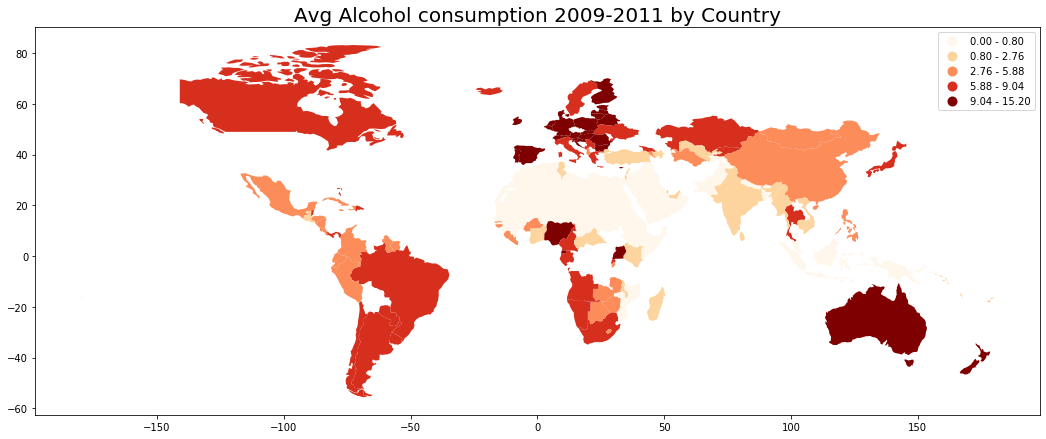

In [38]:
# Draw Alcohol consumptions by each country for the second time period 2009-2011
pylab.rcParams['figure.figsize'] = 18, 18
fig, ax = plt.subplots(1, 1)
ax.set_title("Avg Alcohol consumption 2009-2011 by Country", fontsize=20)
world.plot(column='Alcohol_com2',
           ax=ax,
           legend=True,
#            legend_kwds={'labels': "Avg Alcohol_2015-2017 by Country",'legend': "horizontal"})
           cmap='OrRd',
           scheme='quantiles')
plt.show()

### 3.1.3 Identification and visualization of countries that experienced dramatically Alcohol consumption changes between two time periods

This step will be used to later examine this countries qualitatively (see datastory)

In [39]:
# Add a column name change by computing Alcohol_com1 minus Alcohol com2
world['change'] = world.apply(lambda x: float(x.Alcohol_com1) - float(x.Alcohol_com2), axis=1)

# Extract the countries which experienced drop larger than 0.5 liter per capita 
# and increase larger than 0.5 liter per capita
world_loc = world.loc[(world['change']>0.5)|(world['change']<-0.5)]
world_loc[{'name', 'change'}].head()

change        name
2     -0.7  Kazakhstan
18     1.0     Uruguay
19    -0.8      Brazil
30    -1.1    Suriname
31    -0.6     Ecuador

In [40]:
# Add change_label to identify those countries with significant change
world['change_label'] = world.apply(lambda x: 1 if (float(x.change)>0.5)|(float(x.change)<-0.5) else 0, axis=1)
world.describe()

pop_est    gdp_md_est  Alcohol_com1  Alcohol_com2      change  \
count  1.400000e+02  1.400000e+02    140.000000    140.000000  140.000000   
mean   4.539803e+07  6.086109e+05      4.729286      4.922857   -0.193571   
std    1.612972e+08  2.026684e+06      3.791006      4.036280    0.838482   
min    2.828140e+05  7.230000e+02      0.000000      0.000000   -4.700000   
25%    4.455769e+06  2.902750e+04      1.300000      1.250000   -0.325000   
50%    1.069048e+07  9.448000e+04      3.950000      4.100000    0.000000   
75%    2.947544e+07  4.373250e+05      7.625000      8.050000    0.200000   
max    1.379303e+09  2.114000e+07     15.800000     15.200000    1.500000   

       change_label  
count    140.000000  
mean       0.278571  
std        0.449906  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:138: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:140: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


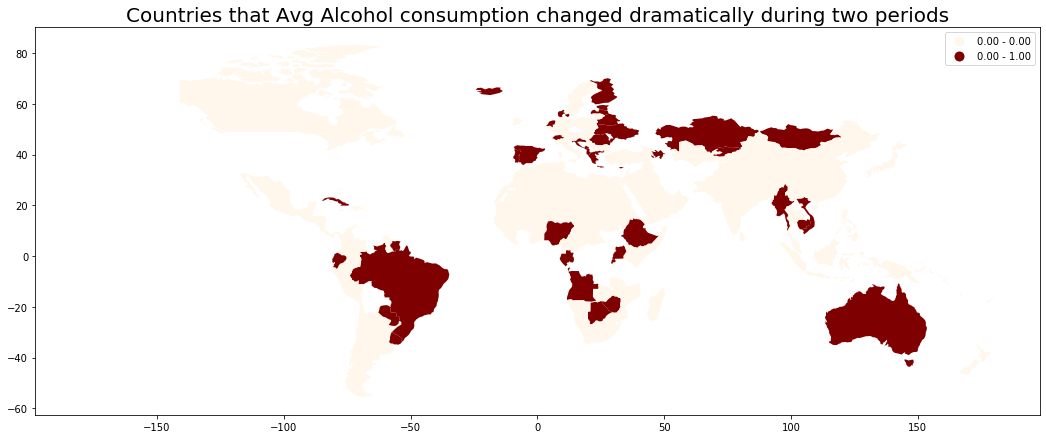

In [41]:
# Plot those countries with significant change on map
pylab.rcParams['figure.figsize'] = 18, 18
fig, ax = plt.subplots(1, 1)
ax.set_title("Countries that Avg Alcohol consumption changed dramatically during two periods", fontsize=20)
world.plot(column='change_label',
           ax=ax,
           legend=True,
#            legend_kwds={'labels': "Avg Alcohol_2015-2017 by Country",'legend': "horizontal"})
           cmap='OrRd',
           scheme='quantiles')
plt.show()

### 3.1.3 Visualization Religions by country

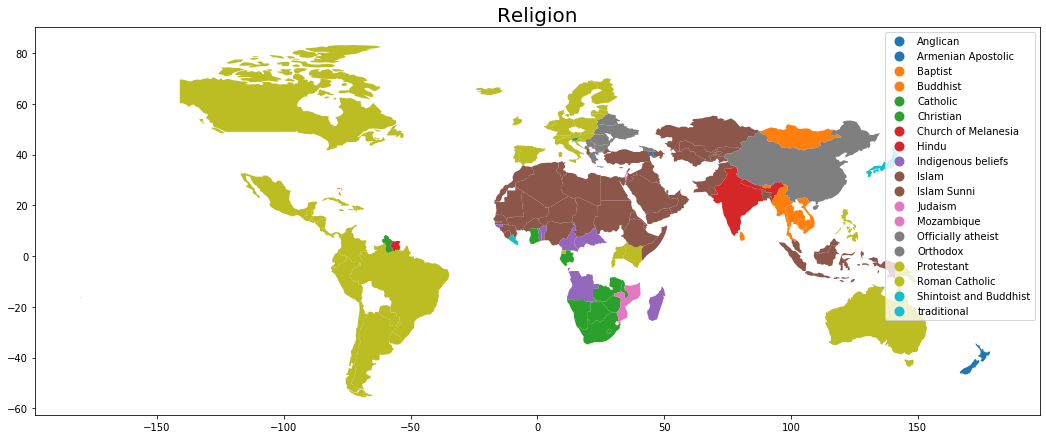

In [42]:
# plot religions division for countries
pylab.rcParams['figure.figsize'] = 18, 18
fig, ax = plt.subplots(1, 1)
ax.set_title("Religion", fontsize=20)
world.plot(column='Religion', ax=ax, legend=True)
plt.show()

In [43]:
# calculate the mean of alcohol consumptions for each Region
df_region = world.groupby('Region').mean()
df_region.reset_index(inplace=True)
df_region.head()

Region       pop_est    gdp_md_est  \
0                       African Group  2.405089e+07  1.313070e+05   
1                  Asia-Pacific Group  1.145525e+08  1.393628e+06   
2              Eastern European Group  9.833712e+06  1.836578e+05   
3  Latin American and Caribbean Group  2.531567e+07  3.880110e+05   
4   Western European and Others Group  2.191894e+07  8.579313e+05   

   Alcohol_com1  Alcohol_com2    change  change_label  
0      2.955814      3.030233 -0.074419      0.186047  
1      2.280556      2.275000  0.005556      0.194444  
2      9.022222      9.688889 -0.666667      0.500000  
3      5.278261      5.317391 -0.039130      0.260870  
4      8.455000      9.015000 -0.560000      0.450000

In [44]:
# calculate the mean of alcohol consumptions for each Religion
df_religion = world.groupby('Religion').mean()
df_religion.reset_index(inplace=True)
df_religion.head()

Religion       pop_est     gdp_md_est  Alcohol_com1  \
0            Anglican  4.510327e+06  174800.000000      9.100000   
1  Armenian Apostolic  3.045191e+06   26300.000000      3.800000   
2             Baptist  3.299880e+05    9066.000000      8.700000   
3            Buddhist  3.744836e+07  343724.571429      3.342857   
4            Catholic  1.972126e+06   68350.000000     10.800000   

   Alcohol_com2    change  change_label  
0      9.500000 -0.400000      0.000000  
1      4.100000 -0.300000      0.000000  
2      8.800000 -0.100000      0.000000  
3      2.871429  0.471429      0.571429  
4     10.500000  0.300000      0.000000

In [45]:
# apply functions to each columns(countries) to get the mean of region or religion they belong to
world['Mean_Alcom1_region'] = world.Region.apply(add_mean1_region, args = (df_region,))
world['Mean_Alcom1_religion'] = world.Religion.apply(add_mean1_religion, args = (df_religion,))
world['Mean_Alcom2_region'] = world.Region.apply(add_mean2_region, args = (df_region,))
world['Mean_Alcom2_religion'] = world.Religion.apply(add_mean2_religion, args = (df_religion,))

In [46]:
# Generate csv files for Global Visualization in DataStory using melt
world_visual = world[['iso2','Alcohol_com1','Mean_Alcom1_region','Mean_Alcom1_religion', 'Alcohol_com2', 'Mean_Alcom2_region','Mean_Alcom2_religion']]
world_visual.head()

iso2  Alcohol_com1  Mean_Alcom1_region  Mean_Alcom1_religion  Alcohol_com2  \
0   FJ           2.2            2.280556              4.636364           2.2   
1   CA           8.1            8.455000              7.187805           8.3   
2   KZ           5.8            2.280556              1.435000           6.5   
3   UZ           1.6            2.280556              1.435000           1.8   
4   PG           0.7            2.280556              7.187805           0.8   

   Mean_Alcom2_region  Mean_Alcom2_religion  
0               2.275              4.454545  
1               9.015              7.512195  
2               2.275              1.555000  
3               2.275              1.555000  
4               2.275              7.512195

In [47]:
world_visual_final = pd.melt(world_visual, id_vars=['iso2'], value_vars = list(world_visual.columns)[1:],
                      var_name = 'Alcohol Consompution Group', value_name = 'Value')
world_visual_final = world_visual_final.sort_values(by='iso2')
world_visual_final.head(10)

iso2 Alcohol Consompution Group     Value
486   AE               Alcohol_com2  1.700000
206   AE         Mean_Alcom1_region  2.280556
346   AE       Mean_Alcom1_religion  1.435000
626   AE         Mean_Alcom2_region  2.275000
766   AE       Mean_Alcom2_religion  1.555000
66    AE               Alcohol_com1  2.100000
381   AL       Mean_Alcom1_religion  1.435000
661   AL         Mean_Alcom2_region  9.688889
521   AL               Alcohol_com2  5.700000
241   AL         Mean_Alcom1_region  9.022222

In [48]:
world_visual_final.to_csv(dataprocessed_PATH+'world_visual_consumption.csv')
world_visual.columns

Index(['iso2', 'Alcohol_com1', 'Mean_Alcom1_region', 'Mean_Alcom1_religion',
       'Alcohol_com2', 'Mean_Alcom2_region', 'Mean_Alcom2_religion'],
      dtype='object')

## 3.2  Visualize policies

We identify three different means used by states to reduce the alcohol consumption:
* charge money for alcohol production, retail and consumption
* make the population aware of the dangers of alcohol
* restrict access to alcohol

In [49]:
# Grouping policies
groups = ['Charges', 'Awareness','Restrictions', 'Code', 'Region', 'Religion']
hierarchy = pd.DataFrame(columns=groups)

In [50]:
# gets the list of column names
age_limits = list(df_age_limits.drop(labels={'Country','Year'},axis=1))
awareness = list(df_community_actions.drop(labels={'Country','Year'},axis=1))
health = list(df_health_warning.drop(labels={'Country','Year'},axis=1))
licence_production = list(df_liscence_production.drop(labels={'Country','Year'},axis=1))
licence_retail = list(df_liscence_retail.drop(labels={'Country','Year'},axis=1))
charge = list(df_tax.drop(labels={'Country','Year'},axis=1))
restriction = list(df_public_use.drop(labels={'Country','Year'},axis=1))

# groups relevant columns together
restriction.extend(age_limits)
awareness.extend(health)
charge.extend(licence_production)
charge.extend(licence_retail)

In [51]:
hierarchy['Charges'] = df_all[charge].mean(axis=1)
hierarchy['Awareness'] = df_all[awareness].mean(axis=1)
hierarchy['Restrictions'] = df_all[restriction].mean(axis=1)
hierarchy['Code'] = df_all['Code']
hierarchy['Region'] = df_all['Region']
hierarchy['Religion']= df_all['Religion']
hierarchy.head()

Charges  Awareness  Restrictions Code  \
Country                                               
Afghanistan  0.816703   0.031843      1.000000  AFG   
Albania      1.000000   0.333333      0.550667  ALB   
Algeria      0.666667   0.000000      0.744000  DZA   
Andorra      1.000000   0.000000      0.277333  AND   
Angola       1.000000   0.333333      0.310667  AGO   

                                        Region            Religion  
Country                                                             
Afghanistan                 Asia-Pacific Group               Islam  
Albania                 Eastern European Group               Islam  
Algeria                          African Group               Islam  
Andorra      Western European and Others Group      Roman Catholic  
Angola                           African Group  Indigenous beliefs

In [52]:
# what is the most common approach
hierarchy.mean(axis=0)

Charges         0.818824
Awareness       0.395354
Restrictions    0.493117
dtype: float64

We can observe that in the world the most common alcohol control policy is to charge the consumer an extra fee.
This makes sense as it is the easiest  to enforce also for lower-income countries, who do not have the budget to have government programmes to reduce alcohol consumption

We look a bit closer inside each category

In [53]:
df_policy_mean = df_policy.mean()

In [54]:
bar_restriction = df_policy_mean[restriction]
bar_awareness = df_policy_mean[awareness]
bar_charge = df_policy_mean[charge]

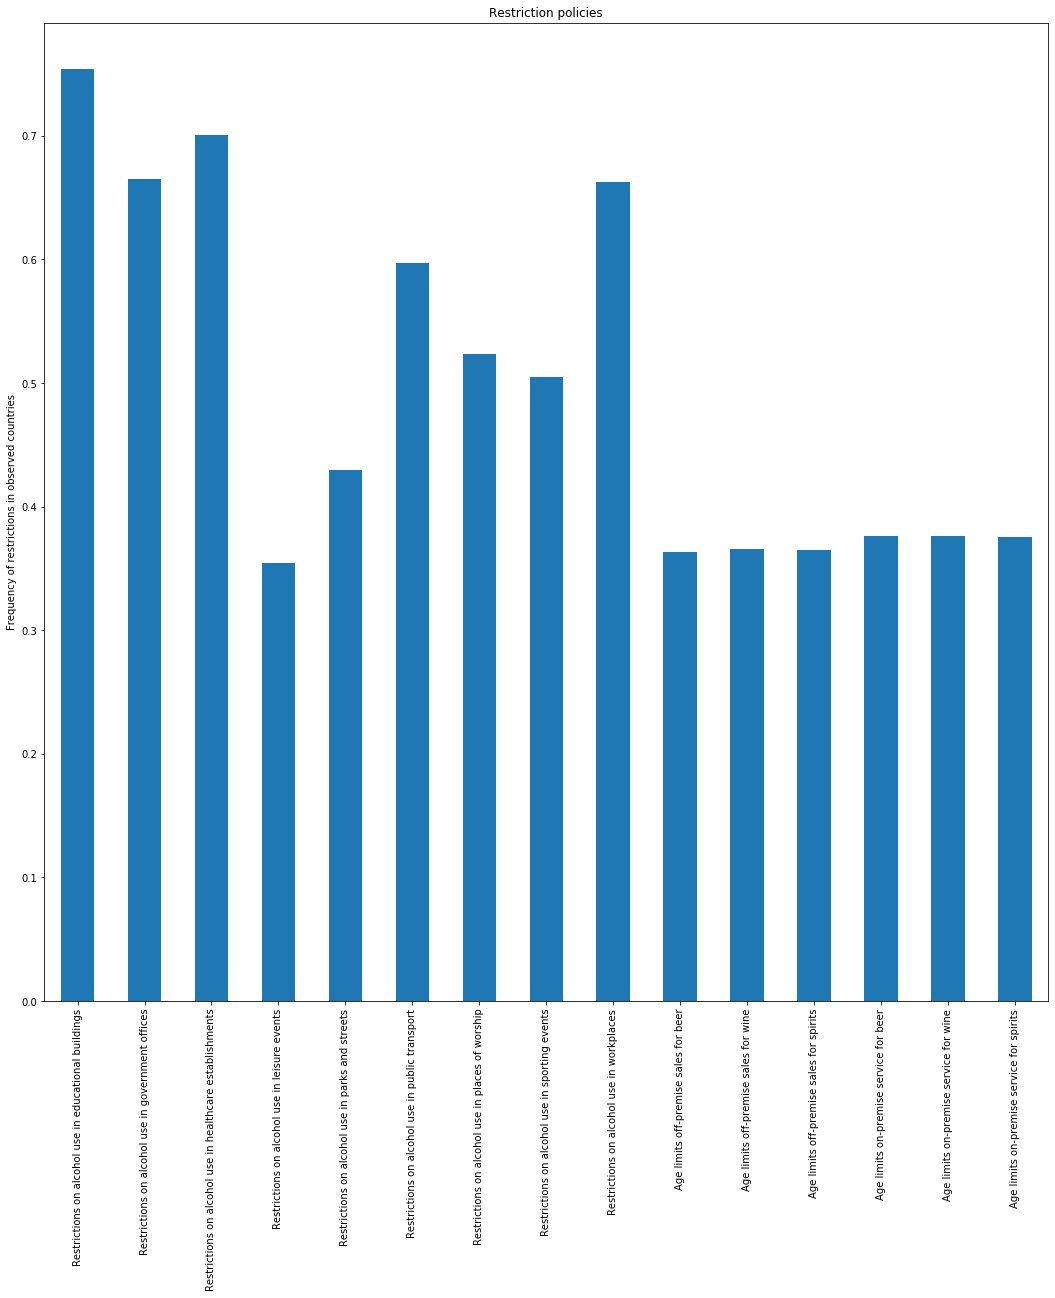

In [55]:
bar_restriction.plot(kind='bar', stacked=True)
plt.title('Restriction policies')
plt.ylabel('Frequency of restrictions in observed countries')
plt.show()

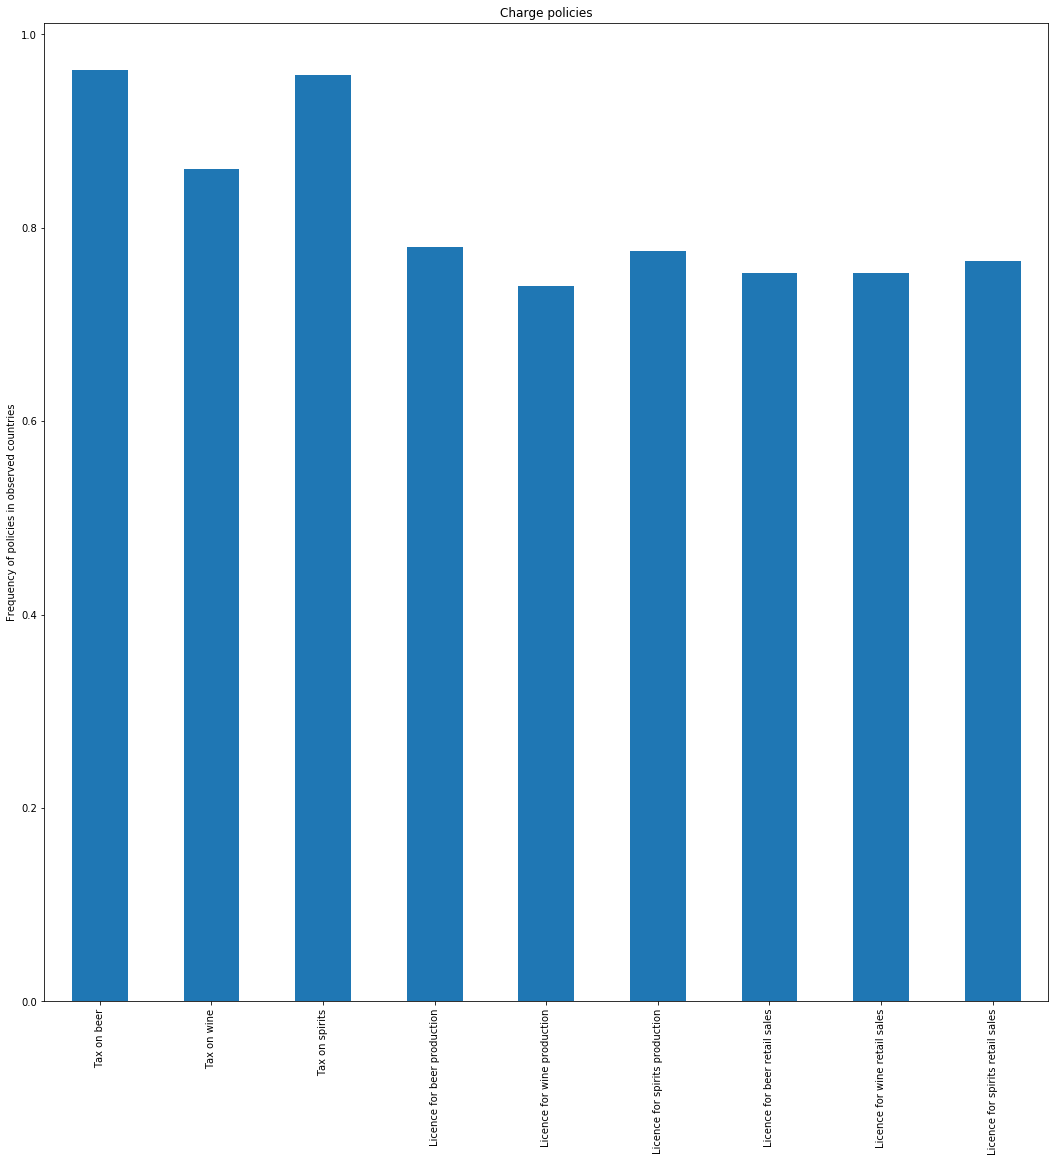

In [56]:
bar_charge.plot(kind='bar', stacked=True)
plt.title('Charge policies')
plt.ylabel('Frequency of policies in observed countries')
plt.show()

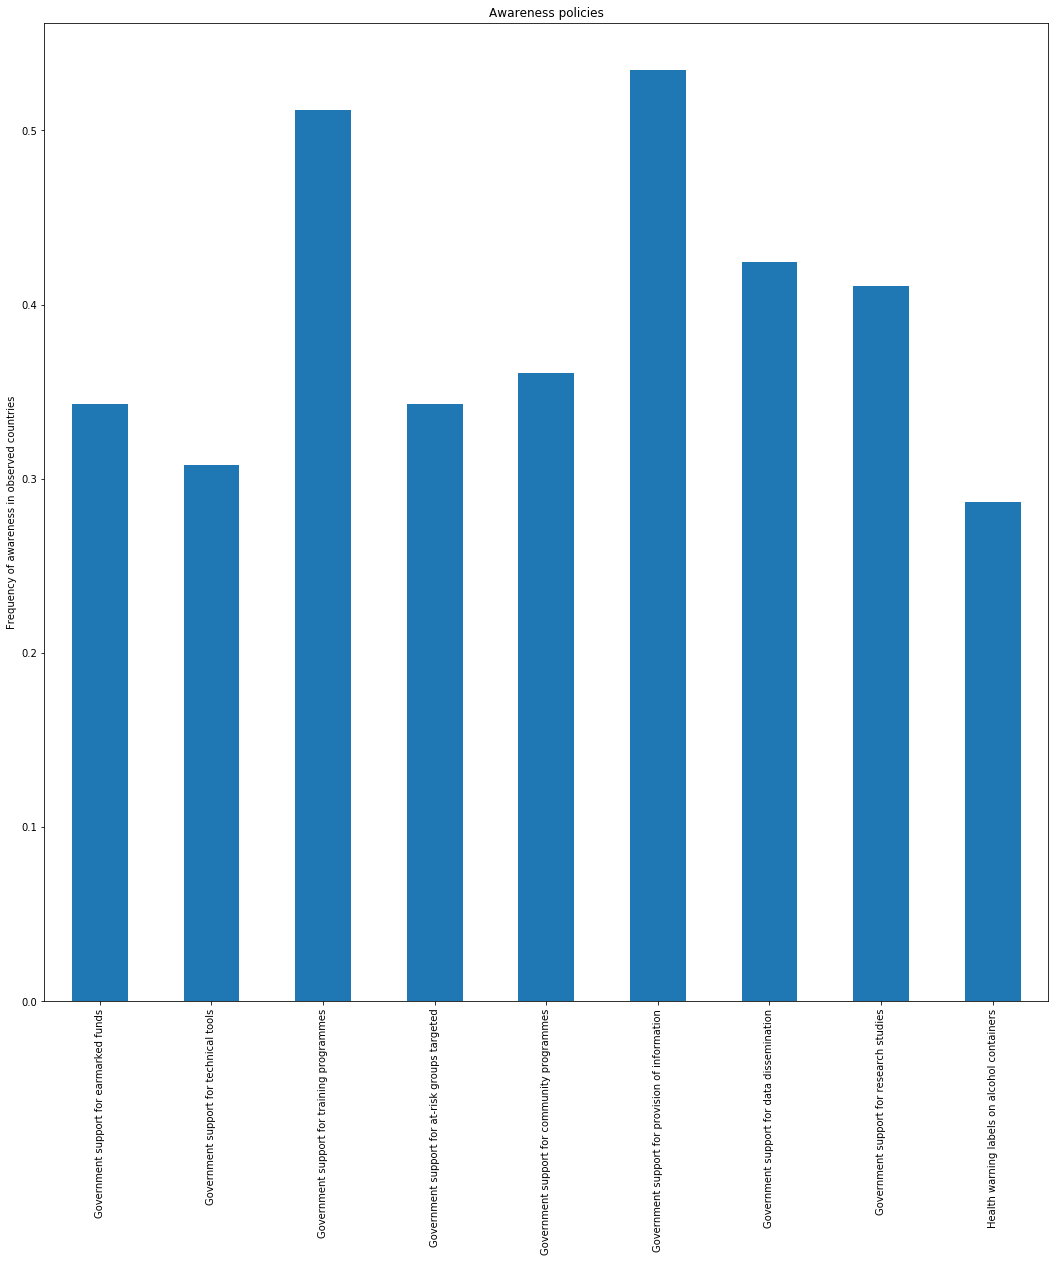

In [57]:
bar_awareness.plot(kind='bar', stacked=True)
# Add title and axis names
plt.title('Awareness policies')
plt.ylabel('Frequency of awareness in observed countries')
plt.show()

Being restriction policies a collection of many different policies there is a difference in the usage by countries of these policies. We can observe though that all these policies are not as popular as taxing alcoholic beverages

## 3.3 Policies by region and religion

we want to do the same analysis but by grouping the policies by country and religion

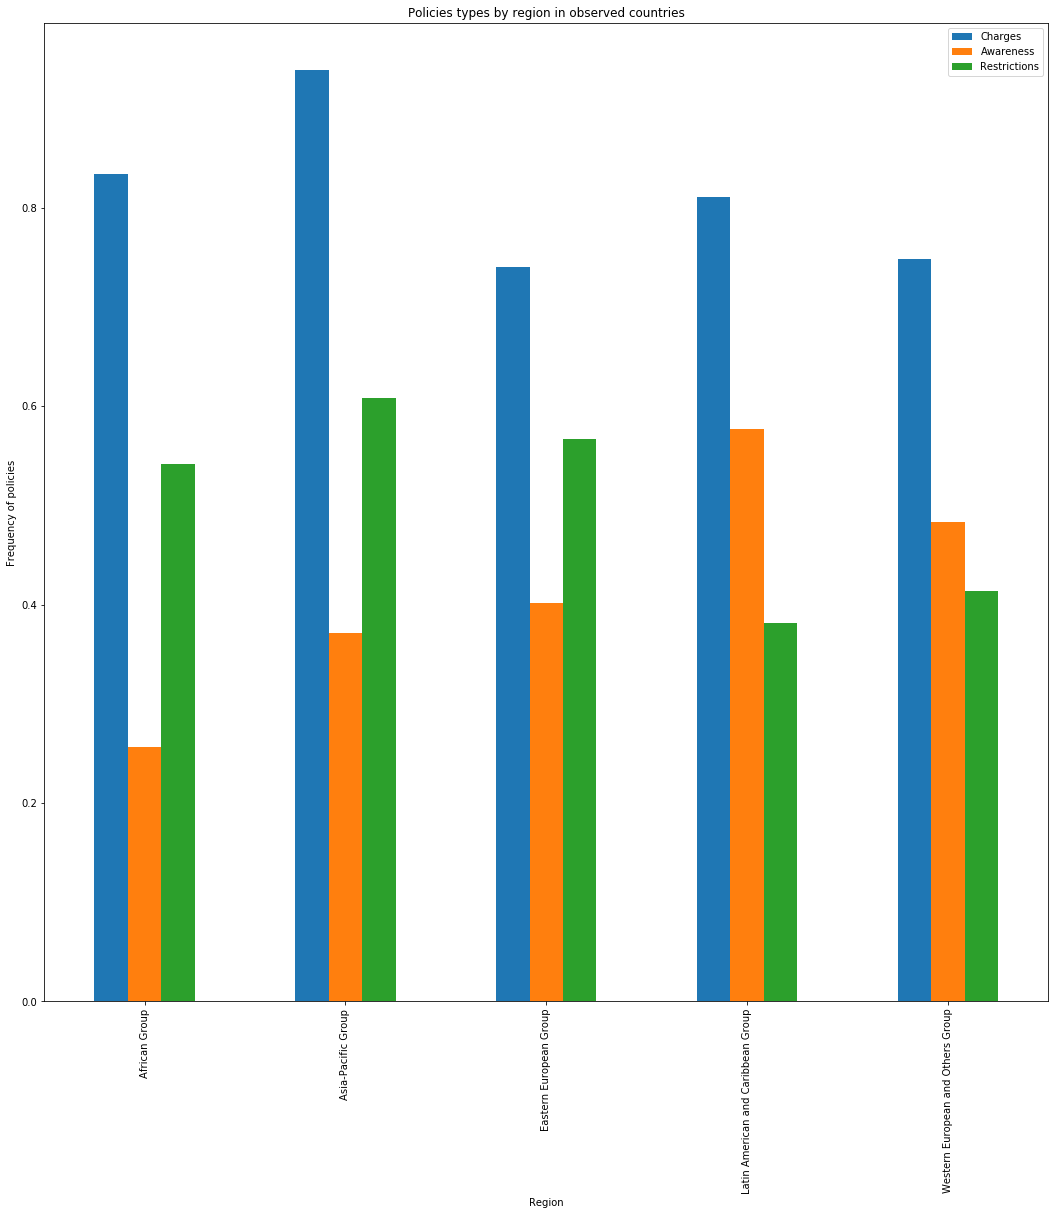

In [58]:
mean_by_region = hierarchy.groupby('Region').mean()
mean_by_region.plot(kind= 'bar')
plt.ylabel('Frequency of policies')
plt.title('Policies types by region in observed countries')
plt.show()

We can observe the popularity of different kind of policies is similar for different regions. The hypothesis made above about awareness being a policy put forward by developed countries does not stand as Western Europe has little difference with the other region in this category

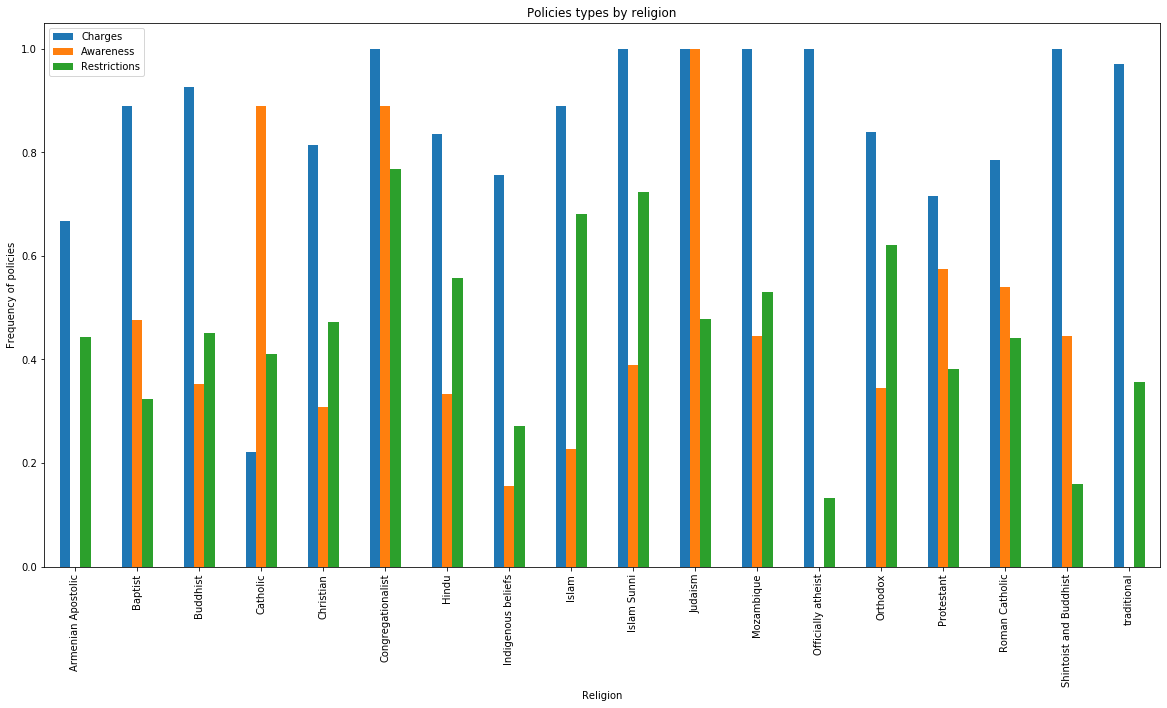

In [59]:
mean_by_religion = hierarchy.groupby('Religion').mean()
mean_by_religion.plot(kind= 'bar', figsize=(20,10))
plt.ylabel('Frequency of policies')
plt.title('Policies types by religion')
plt.show()

We can observe a few differences between countries with different religions
* Islamic and officially atheist (China) coutries have high number of regulations. The former due to the ban of alcohol imposed by the religion, the second due to the autocratic organization of the state
* Christian groups, except Roman Catholic and Orthodox, seem to have fewer restriction policies compared to other countries. 
* Orthodox and non-specified Christian countries have the lowest usage of taxes on alcoholic beverages. This can be due to the high cultural importance of alcohol in many post-soviet nations which are also orthodox

# 4. Identification of influence factors

## 4.1  Clustering

In [60]:
#removing unnecessary columns
df_for_clustering = df_all.drop(columns=['Code', 'Region', 'Religion'])

In [61]:
#correcting the data type
for c in ("HDI_2016", "Unemployment, total (% of labour force)", "Median age (years)", "Gross domestic product (GDP) per capita (2011 PPP $)", "Education Index"):
    df_for_clustering[c] = pd.to_numeric(df_for_clustering[c], errors='coerce')

#fill nan with the mean values
df_for_clustering.fillna(df_for_clustering.mean(), inplace=True)

In [62]:
#normalizing the values
clustering_normalized_df = (df_for_clustering-df_for_clustering.min())/(df_for_clustering.max()-df_for_clustering.min())

In [63]:
#get the alcohol consumption values
alc_consumption = pd.DataFrame(data={"Alcohol_per_capita": finaldf["Alcohol_per_capita_2015-2017"]},
                               dtype=float)
alc_consumption.head()

Alcohol_per_capita
Country                        
Algeria                     0.6
Angola                      5.0
Benin                       1.6
Botswana                    6.2
Burkinafaso                 4.9

In [64]:
#join dfs, remove countries with missing values for alcohol consumption 
clustering_normalized_df = clustering_normalized_df.join(alc_consumption)
clustering_normalized_df = clustering_normalized_df.dropna()

In [65]:
#turn alcohol per capita to numeric type
clustering_normalized_df["Alcohol_per_capita"] = pd.to_numeric(clustering_normalized_df["Alcohol_per_capita"], errors='coerce')

In [66]:
clustering_normalized_df.head(10)

Age limits off-premise sales for beer  \
Country                                             
Albania                                  0.360000   
Algeria                                  0.360000   
Andorra                                  0.360000   
Angola                                   0.360000   
Argentina                                0.360000   
Armenia                                  0.360000   
Australia                                0.360000   
Austria                                  0.363294   
Azerbaijan                               0.360000   
Bahamas                                  0.360000   

            Age limits off-premise sales for wine  \
Country                                             
Albania                                  0.360000   
Algeria                                  0.360000   
Andorra                                  0.360000   
Angola                                   0.360000   
Argentina                                0.360000   
Armenia                                  0.360000   
Australia                                0.360000   
Austria                                  0.365647   
Azerbaijan                               0.360000   
Bahamas                                  0.360000   

            Age limits off-premise sales for spirits  \
Country                                                
Albania                                     0.360000   
Algeria                                     0.360000   
Andorra                                     0.360000   
Angola                                      0.360000   
Argentina                                   0.360000   
Armenia                                     0.360000   
Australia                                   0.360000   
Austria                                     0.365059   
Azerbaijan                                  0.360000   
Bahamas                                     0.360000   

            Age limits on-premise service for beer  \
Country                                              
Albania                                   0.360000   
Algeria                                   0.360000   
Andorra                                   0.360000   
Angola                                    0.360000   
Argentina                                 0.360000   
Armenia                                   0.360000   
Australia                                 0.360000   
Austria                                   0.376235   
Azerbaijan                                0.360000   
Bahamas                                   0.360000   

            Age limits on-premise service for wine  \
Country                                              
Albania                                   0.360000   
Algeria                                   0.360000   
Andorra                                   0.360000   
Angola                                    0.360000   
Argentina                                 0.360000   
Armenia                                   0.360000   
Australia                                 0.360000   
Austria                                   0.376235   
Azerbaijan                                0.360000   
Bahamas                                   0.360000   

            Age limits on-premise service for spirits  \
Country                                                 
Albania                                      0.360000   
Algeria                                      0.360000   
Andorra                                      0.360000   
Angola                                       0.360000   
Argentina                                    0.360000   
Armenia                                      0.360000   
Australia                                    0.360000   
Austria                                      0.375647   
Azerbaijan                                   0.360000   
Bahamas                                      0.360000   

            Government support for earmarked funds  \
Country                     

In [67]:
clustering_normalized_np = clustering_normalized_df.to_numpy(copy=True)

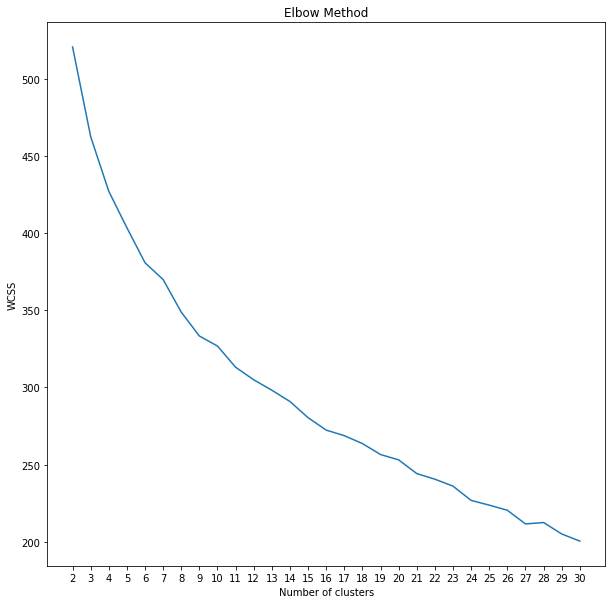

In [68]:
#trying to determine the optimal number of clusters with k-means for all the features with the elbow method
plt.rcParams['figure.figsize'] = [10, 10]
wcss = []
for i in range(2, 31):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(clustering_normalized_np[:,:-1])
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 31), wcss)
plt.xticks(np.arange(2, 31, 1.0))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Due to "the curse of dimensionality", it is difficult to determine the optimal number of clusters for k-means with all the features

Therefore, we will try to find the features that are most indicative of the alcohol consumtion by using linear regression


## 4.2 Feature selection by weights from cluster and correlation

In [69]:
#running linear regression on features, with the target being alcohol consumption
X = clustering_normalized_np[:,:-1]
y = clustering_normalized_np[:,-1:]

mse = np.zeros(100)
warnings.filterwarnings('ignore')
for a in range(100):
    mse[a] = -np.mean(cross_val_score(Ridge(alpha=a/10.0), X=X, y=y, cv=5, scoring='neg_mean_squared_error'));

In [70]:
#getting weights for the best performing alpha value
best_alpha = np.argmin(mse)
ridge = Ridge(best_alpha/10.0)
ridge.fit(X, y);

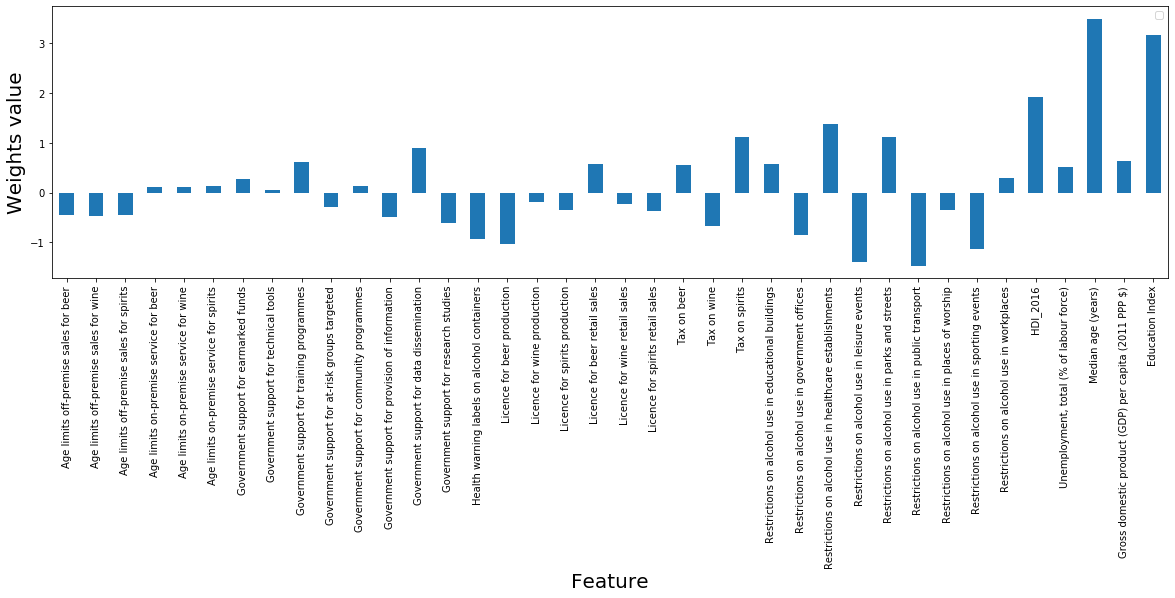

In [71]:
#plotting weights
plt.rcParams['figure.figsize'] = [20, 5]
df = pd.DataFrame({'_': ridge.coef_[0]}, index=clustering_normalized_df.columns.tolist()[:-1])
q = df.plot.bar()
q.set_xlabel('Feature', size=20)
q.set_ylabel('Weights value', size=20);

Alternatively, we can use correlations (as in hw2) to see which features are most indicative of the overall alcohol consumption

In [72]:
#calculating the correlations with alcohol consumption
correlations = clustering_normalized_df.corr().iloc[-1][:-1]
correlations = correlations.sort_values(ascending=False)
correlations = pd.DataFrame(correlations).T
correlations

Median age (years)  Education Index  HDI_2016  \
Alcohol_per_capita            0.693265         0.691215  0.641083   

                    Gross domestic product (GDP) per capita (2011 PPP $)  \
Alcohol_per_capita                                           0.522115      

                    Government support for earmarked funds  \
Alcohol_per_capita                                0.308649   

                    Government support for data dissemination  \
Alcohol_per_capita                                    0.26196   

                    Government support for technical tools  \
Alcohol_per_capita                                0.246836   

                    Government support for training programmes  \
Alcohol_per_capita                                    0.240992   

                    Government support for provision of information  \
Alcohol_per_capita                                         0.193175   

                    Tax on spirits  ...  \
Alcohol_per_capita        0.161293  ...   

                    Restrictions on alcohol use in sporting events  \
Alcohol_per_capita                                       -0.245377   

                    Licence for beer retail sales  \
Alcohol_per_capita                      -0.249569   

                    Licence for spirits retail sales  \
Alcohol_per_capita                         -0.251571   

                    Licence for wine retail sales  \
Alcohol_per_capita                      -0.268238   

                    Restrictions on alcohol use in public transport  \
Alcohol_per_capita                                        -0.280066   

                    Licence for beer production  \
Alcohol_per_capita                    -0.293232   

                    Restrictions on alcohol use in workplaces  Tax on wine  \
Alcohol_per_capita                                  -0.308958    -0.336959   

                    Restrictions on alcohol use in places of worship  \
Alcohol_per_capita                                         -0.381656   

                    Restrictions on alcohol use in government offices  
Alcohol_per_capita                                          -0.399614  

[1 rows x 38 columns]

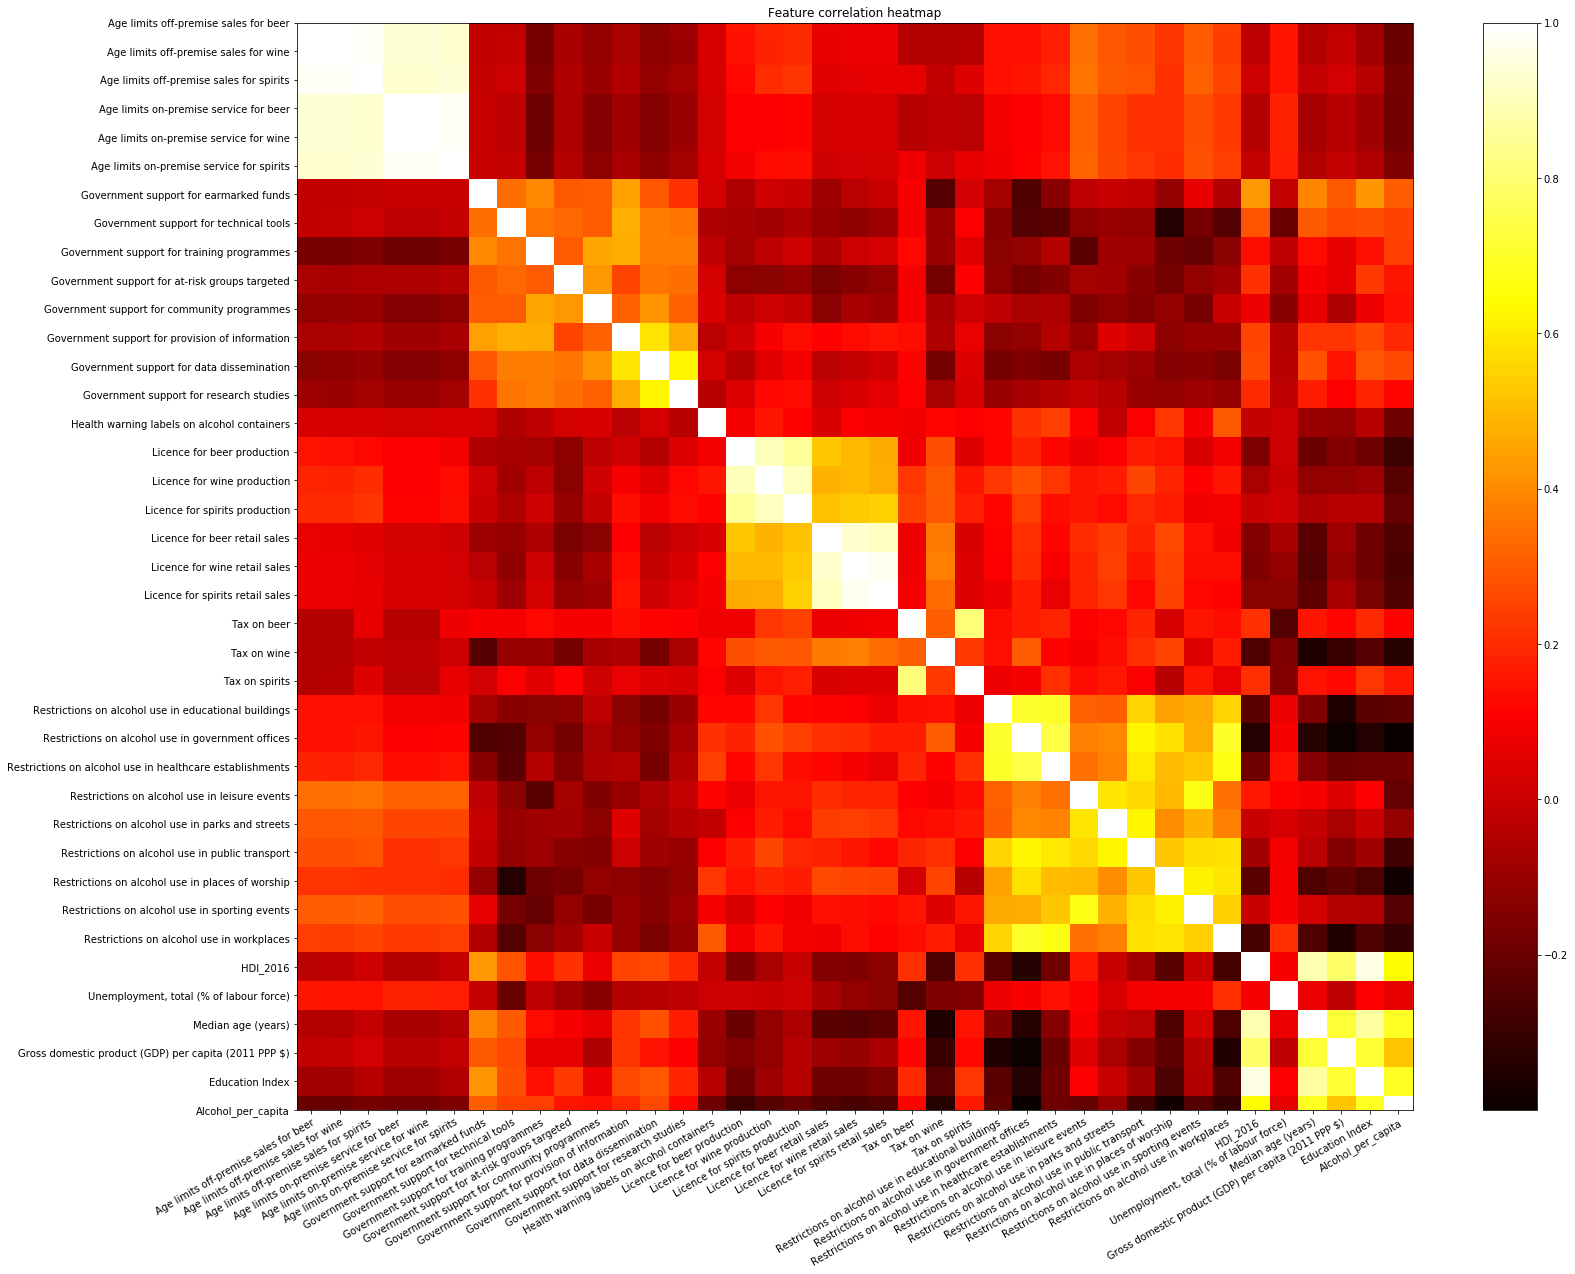

In [73]:
# Plotting the feature correlations heatmap for visualization
corr = clustering_normalized_df.corr()
plt.rcParams['figure.figsize'] = [25, 20]
h = plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.colorbar(h)
plt.title("Feature correlation heatmap")
plt.xticks(np.arange(39), corr.index, rotation=30, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(39), corr.index)
plt.show()

The heatmap shows clear groups of policies and restrictions that have higher correlations within the group, indicating that they are not independent, which is to be expected. If there is a restriction on alcohol use in parks and streets in a certain country, it is more likely that it also has a restriction on alcohol use in public transport, while if a licence is necessary for beer production, almost certainly there is one for wine production as well.

The problem is that even if these features have fairly high correlation with alcohol consumption (eg. GDP, Education index and HDI), the strong correlation among themselves mean that there is some redundancy in the information they provide us with. Partially for this reason, the previously generated weights for GDP, for example, are quite low, despite it having one of the highest correlations with the alcohol consumption.

It is also important to note, that the correlation values get as low as -0.45, which represents negative correlation, meaning that the feature in question has an inversed effect on the other feature. For instance, presence of the restriction on alcohol use in government offices seems to indicate a relatively low alcohol consumption in the said country, but also fairly low GDP. We do not know wheather there is a causality between these features, but it is an interesting pattern nonetheless.

In [74]:
#taking features that have |correlation| > 0.3 with alcohol consumption
#in this case, top 5 positively correlating and top 6 negatively correlating features
correlating_features = correlations.columns.tolist()[:5] + correlations.columns.tolist()[-6:]
clustering_normalized_np = clustering_normalized_df[correlating_features].to_numpy(copy=True)

## 4.3 Visualization of clustering countries by important features

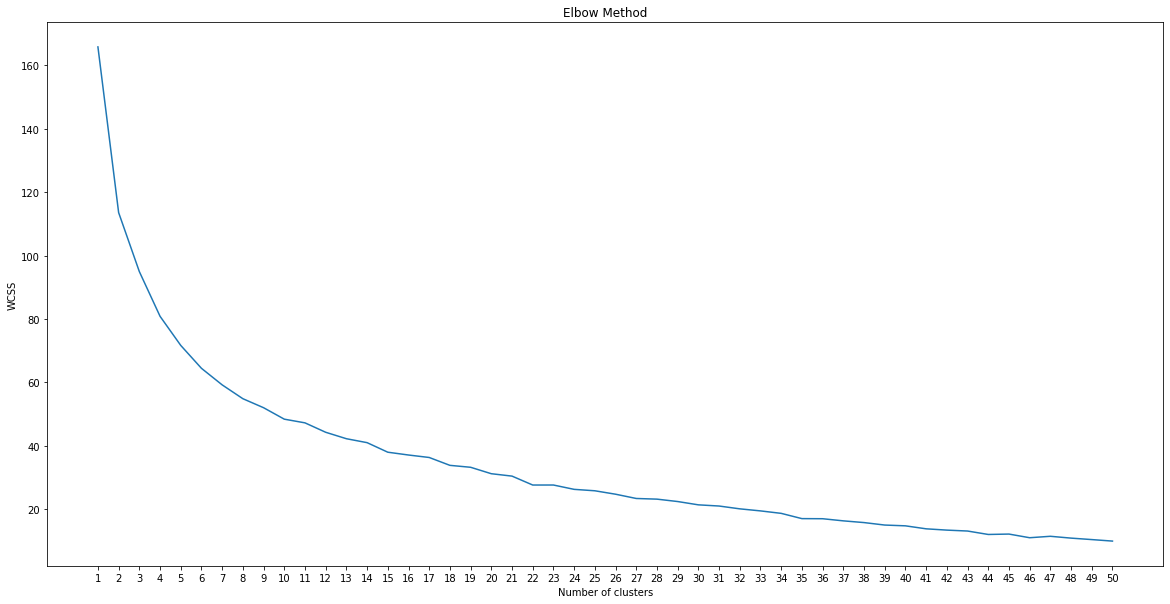

In [75]:
#trying to determine the optimal number of clusters with k-means for the correlating features
plt.rcParams['figure.figsize'] = [20, 10]
wcss = []
for i in range(1, 51):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=10000, n_init=10, random_state=0)
    kmeans.fit(clustering_normalized_np)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 51), wcss)
plt.xticks(np.arange(1, 51, 1.0))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

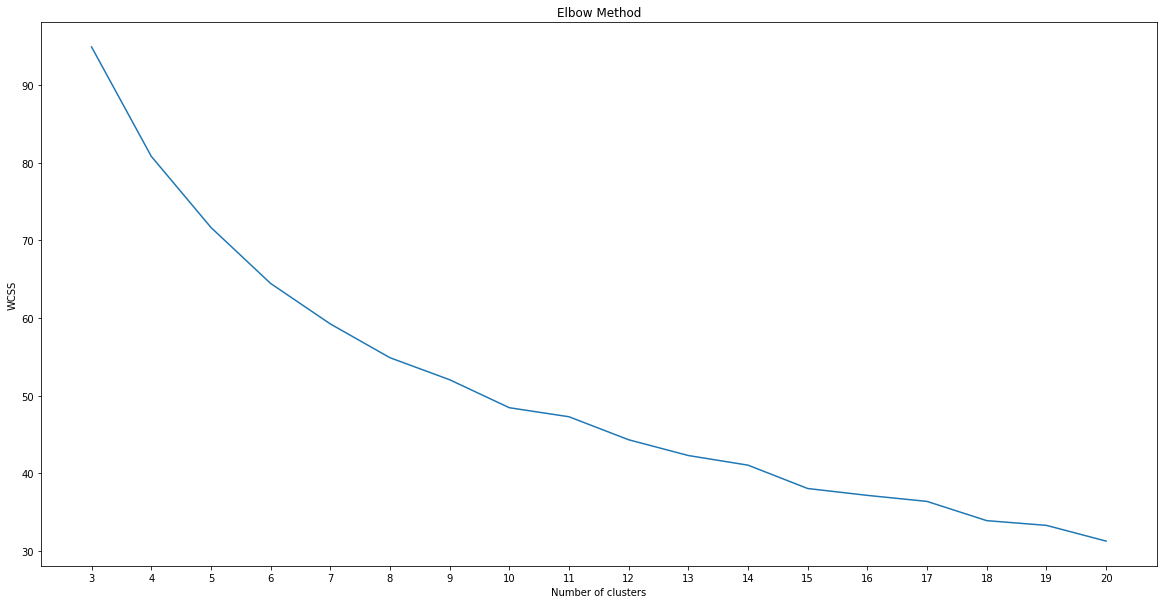

In [76]:
#trying to determine the optimal number of clusters with k-means for the correlating features (zoomed in)
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(range(3, 21), wcss[2:20])
plt.xticks(np.arange(3, 21, 1.0))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

It appears that 9 clusters would be a reasonable choice

In [77]:
#clustering into 9 groups based on 11 selected features
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=10000, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(clustering_normalized_np)

In [78]:
#order clusters by average alcohol consumption
clustering_normalized_df["cluster"] = pred_y
ordered_clusters = clustering_normalized_df.groupby(['cluster']).mean().sort_values(by=['Alcohol_per_capita']).index.tolist()
clustering_normalized_df["cluster"] = clustering_normalized_df["cluster"].apply(lambda x : ordered_clusters[x])

In [79]:
#preparing df for visualization
clustering_df = clustering_normalized_df[["Alcohol_per_capita", "cluster"]]
clustering_df = clustering_df.join(df_all['Code'])
clustering_df = clustering_df[~clustering_df.index.duplicated(keep='first')]
clustering_df = clustering_df.rename(columns={'Code':'iso_a3'})
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.merge(clustering_df, on='iso_a3')

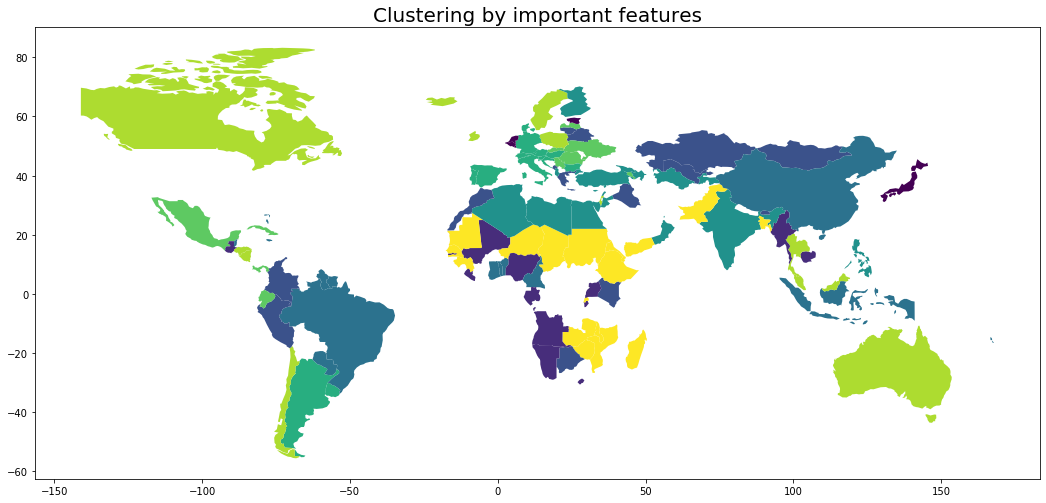

In [80]:
#visualizing clusters on the map
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 18, 18
fig, ax = plt.subplots(1, 1)
ax.set_title("Clustering by important features", fontsize=20)
world.plot(column='cluster', ax=ax);